d:\Work\BMS\Capstone-BMS-Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Work\BMS\Capstone-BMS-Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Work\BMS\Capstone-BMS-Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Work\BMS\Capstone-BMS-Project\venv\lib\site-packages\sklearn\metrics\_classi

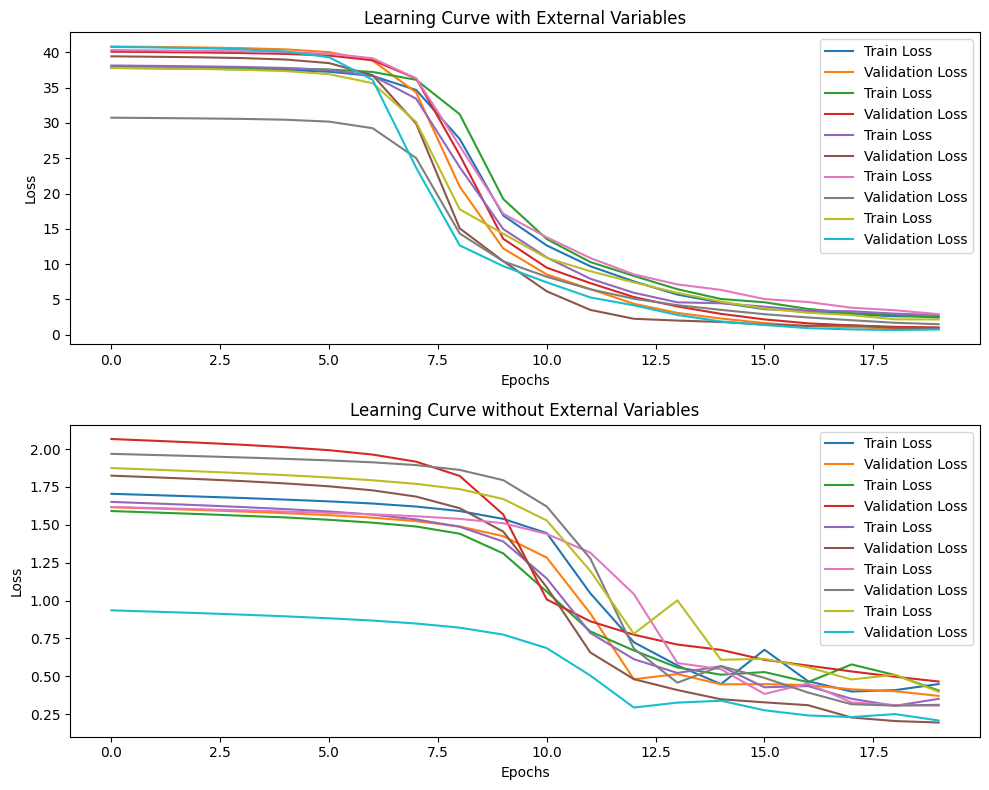

Random Forest
[[ 21   2]
 [  0 211]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        23
           1       0.99      1.00      1.00       211

    accuracy                           0.99       234
   macro avg       1.00      0.96      0.97       234
weighted avg       0.99      0.99      0.99       234

MSE: 0.008645726495726497

Support Vector Machine
[[ 20   3]
 [  0 211]]
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        23
           1       0.99      1.00      0.99       211

    accuracy                           0.99       234
   macro avg       0.99      0.93      0.96       234
weighted avg       0.99      0.99      0.99       234

MSE: 0.010319343016791169

k-Nearest Neighbors
[[ 20   3]
 [  0 211]]
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        23
           1       0.99      1.00      0.99       211

  

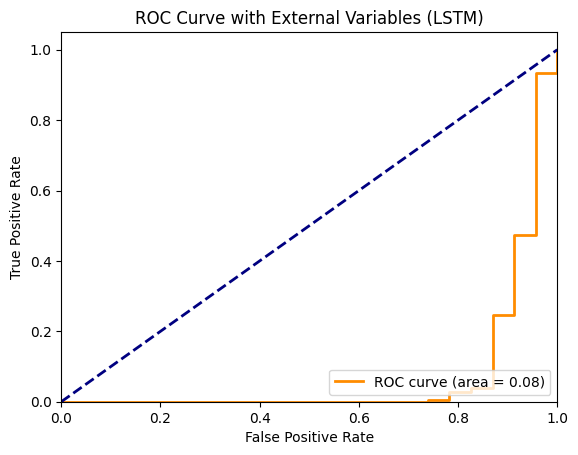

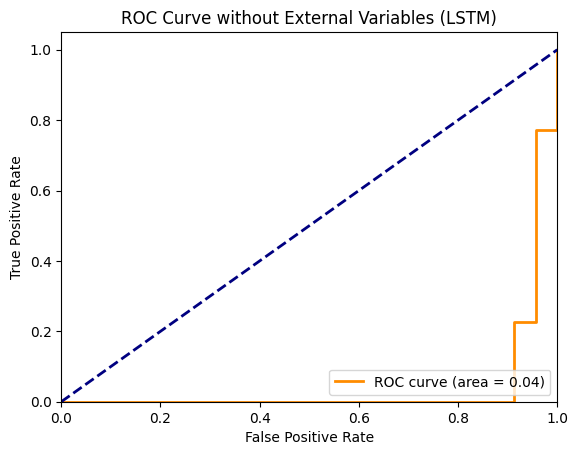

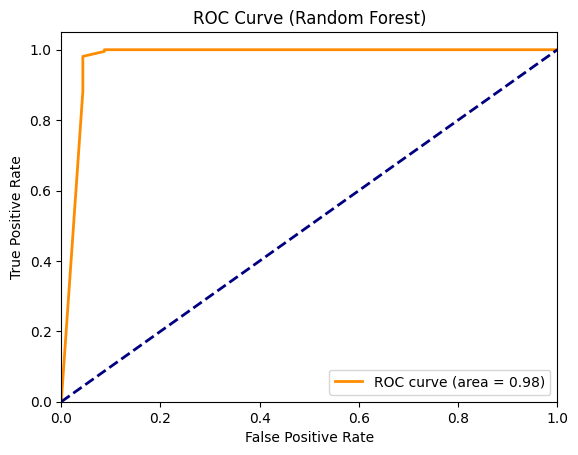

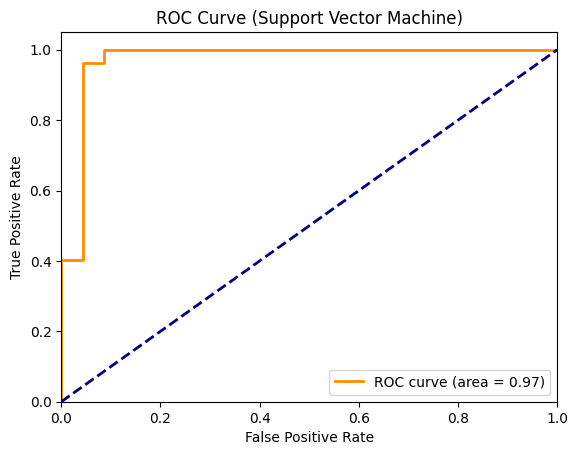

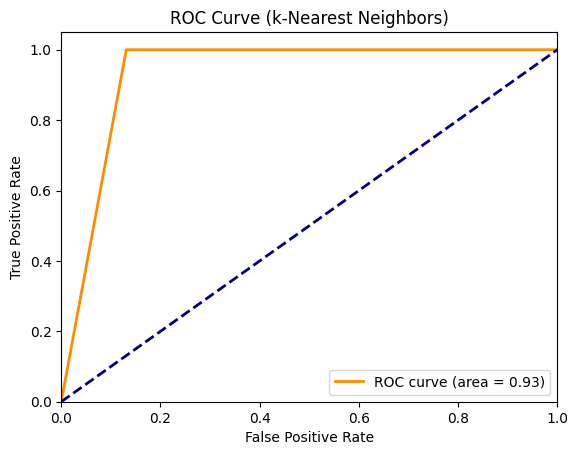

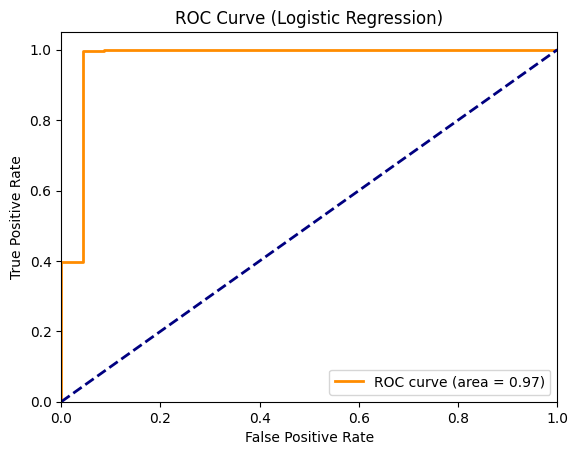

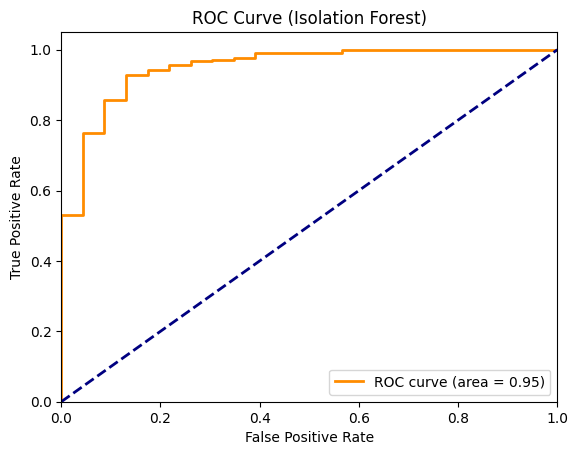

Precision t-statistic: nan, p-value: nan
Recall t-statistic: 6.20994649300009, p-value: 2.410304638139244e-09
With External Variables (LSTM)
Best Threshold: 1.731498721345418
Confusion Matrix:
 [[ 19   4]
 [  7 204]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.83      0.78        23
           1       0.98      0.97      0.97       211

    accuracy                           0.95       234
   macro avg       0.86      0.90      0.87       234
weighted avg       0.96      0.95      0.95       234

Average Precision: 0.998
Average Recall: 1.0
MSE: 0.04700854700854701

Without External Variables (LSTM)
Best Threshold: 0.3780964478940346
Confusion Matrix:
 [[ 21   2]
 [  0 211]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95        23
           1       0.99      1.00      1.00       211

    accuracy                           0.99       234
   macro

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, auc, mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from scipy.stats import ttest_rel
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
file_path = 'baseline_data.csv'
df = pd.read_csv(file_path, parse_dates=['time'], index_col='time')

# Check for missing values and fill if any
df.fillna(method='ffill', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity']] = scaler.fit_transform(
    df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity']]
)

# Feature engineering
df['hour_of_day'] = df.index.hour

# Function to add synthetic anomalies
def add_synthetic_anomalies(df, anomaly_fraction=0.1, seed=42):
    np.random.seed(seed)
    df_with_anomalies = df.copy()
    num_anomalies = int(len(df) * anomaly_fraction)
    anomaly_indices = np.random.choice(df.index, num_anomalies, replace=False)
    df_with_anomalies.loc[anomaly_indices, 'device_temperature'] += np.random.normal(5, 2, size=num_anomalies)
    df_with_anomalies['label'] = 1
    df_with_anomalies.loc[anomaly_indices, 'label'] = 0
    return df_with_anomalies

# Add synthetic anomalies
df_with_anomalies = add_synthetic_anomalies(df)

# Ensure balanced train-test split
train, test = train_test_split(df_with_anomalies, test_size=0.2, stratify=df_with_anomalies['label'], random_state=42)
train, val = train_test_split(train, test_size=0.2, stratify=train['label'], random_state=42)

# Function to prepare data and train the LSTM model
def train_and_evaluate_lstm(features, train, val, test, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    precision_scores = []
    recall_scores = []
    best_thresholds = []
    history_list = []
    
    for train_index, val_index in kf.split(train):
        train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]
        X_train = train_fold[features].values.reshape((train_fold.shape[0], 1, len(features)))
        X_val = val_fold[features].values.reshape((val_fold.shape[0], 1, len(features)))
        X_test = test[features].values.reshape((test.shape[0], 1, len(features)))

        model = Sequential([
            LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
            Dropout(0.2),
            LSTM(32, activation='relu', return_sequences=False),
            RepeatVector(X_train.shape[1]),
            LSTM(32, activation='relu', return_sequences=True),
            Dropout(0.2),
            LSTM(16, activation='relu', return_sequences=True),
            TimeDistributed(Dense(X_train.shape[2]))
        ])

        optimizer = Adam(learning_rate=0.0005)
        model.compile(optimizer=optimizer, loss='mse')
        history = model.fit(X_train, X_train, epochs=20, batch_size=64, validation_data=(X_val, X_val), verbose=0)
        history_list.append(history)

        X_val_pred = model.predict(X_val)
        val_mse_loss = np.mean(np.square(X_val_pred - X_val), axis=2).flatten()
        
        thresholds = np.linspace(0, max(val_mse_loss), 100)
        precision_scores_fold = []
        recall_scores_fold = []

        for threshold in thresholds:
            y_pred = [1 if score < threshold else 0 for score in val_mse_loss]
            precision = precision_score(val_fold['label'], y_pred)
            recall = recall_score(val_fold['label'], y_pred)
            precision_scores_fold.append(precision)
            recall_scores_fold.append(recall)

        best_threshold = thresholds[np.argmax([p * r for p, r in zip(precision_scores_fold, recall_scores_fold)])]
        best_thresholds.append(best_threshold)
        precision_scores.append(max(precision_scores_fold))
        recall_scores.append(max(recall_scores_fold))
    
    best_threshold = np.mean(best_thresholds)
    X_test_pred = model.predict(X_test)
    test_mse_loss = np.mean(np.square(X_test_pred - X_test), axis=2).flatten()
    y_pred = [1 if score < best_threshold else 0 for score in test_mse_loss]

    cm = confusion_matrix(test['label'], y_pred)
    report = classification_report(test['label'], y_pred)

    # Calculate MSE for the test set
    test_mse = mean_squared_error(test['label'], y_pred)

    return best_threshold, cm, report, np.mean(precision_scores), np.mean(recall_scores), test_mse_loss, test['label'].values, history_list, test_mse

# Train and evaluate the LSTM model with external variables
features_with_external = ['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity', 'hour_of_day']
best_threshold_with_external, cm_with_external, report_with_external, avg_precision_with_external, avg_recall_with_external, test_mse_loss_with_external, test_labels_with_external, history_list_with_external, test_mse_with_external = train_and_evaluate_lstm(features_with_external, train, val, test)

# Train and evaluate the LSTM model without external variables
features_without_external = ['device_temperature', 'device_humidity']
best_threshold_without_external, cm_without_external, report_without_external, avg_precision_without_external, avg_recall_without_external, test_mse_loss_without_external, test_labels_without_external, history_list_without_external, test_mse_without_external = train_and_evaluate_lstm(features_without_external, train, val, test)

# Plot Learning Curves
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
for history in history_list_with_external:
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve with External Variables')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
for history in history_list_without_external:
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve without External Variables')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Traditional Machine Learning Models

# Prepare data
X = df_with_anomalies[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity', 'hour_of_day']]
y = df_with_anomalies['label']
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to train and evaluate traditional ML models
def evaluate_ml_model(model, model_name):
    model.fit(X_train_ml, y_train_ml)
    y_pred = model.predict(X_test_ml)
    print(model_name)
    print(confusion_matrix(y_test_ml, y_pred))
    print(classification_report(y_test_ml, y_pred))

    # Calculate MSE for the test set
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_ml)[:, 1]
    elif hasattr(model, "decision_function"):
        y_pred_proba = model.decision_function(X_test_ml)
    else:
        y_pred_proba = y_pred

    test_mse = mean_squared_error(y_test_ml, y_pred_proba)
    print(f"MSE: {test_mse}\n")

    return y_pred, test_mse

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pred, rf_mse = evaluate_ml_model(rf, "Random Forest")

# Support Vector Machine
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm_pred, svm_mse = evaluate_ml_model(svm, "Support Vector Machine")

# k-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn_pred, knn_mse = evaluate_ml_model(knn, "k-Nearest Neighbors")

# Logistic Regression
lr = LogisticRegression(random_state=42)
lr_pred, lr_mse = evaluate_ml_model(lr, "Logistic Regression")

# Isolation Forest (for anomaly detection)
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_train_ml)
iso_forest_pred = iso_forest.predict(X_test_ml)
iso_forest_pred = np.where(iso_forest_pred == 1, 0, 1)  # Convert -1 to 1 for anomalies
print("Isolation Forest")
print(confusion_matrix(y_test_ml, iso_forest_pred))
print(classification_report(y_test_ml, iso_forest_pred))
iso_forest_mse = mean_squared_error(y_test_ml, iso_forest.decision_function(X_test_ml))
print(f"MSE: {iso_forest_mse}\n")

# Plot ROC Curves
def plot_roc_curve(y_true, y_pred, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(test_labels_with_external, test_mse_loss_with_external, "ROC Curve with External Variables (LSTM)")
plot_roc_curve(test_labels_without_external, test_mse_loss_without_external, "ROC Curve without External Variables (LSTM)")

# For traditional ML models
plot_roc_curve(y_test_ml, rf.predict_proba(X_test_ml)[:, 1], "ROC Curve (Random Forest)")
plot_roc_curve(y_test_ml, svm.decision_function(X_test_ml), "ROC Curve (Support Vector Machine)")
plot_roc_curve(y_test_ml, knn.predict_proba(X_test_ml)[:, 1], "ROC Curve (k-Nearest Neighbors)")
plot_roc_curve(y_test_ml, lr.predict_proba(X_test_ml)[:, 1], "ROC Curve (Logistic Regression)")
iso_forest_scores = iso_forest.decision_function(X_test_ml)
plot_roc_curve(y_test_ml, iso_forest_scores, "ROC Curve (Isolation Forest)")

# Statistical significance test
t_stat_precision, p_value_precision = ttest_rel(test_labels_with_external, test_labels_without_external)
t_stat_recall, p_value_recall = ttest_rel(test_mse_loss_with_external, test_mse_loss_without_external)
print(f"Precision t-statistic: {t_stat_precision}, p-value: {p_value_precision}")
print(f"Recall t-statistic: {t_stat_recall}, p-value: {p_value_recall}")

# Print results
print("With External Variables (LSTM)")
print("Best Threshold:", best_threshold_with_external)
print("Confusion Matrix:\n", cm_with_external)
print("Classification Report:\n", report_with_external)
print("Average Precision:", avg_precision_with_external)
print("Average Recall:", avg_recall_with_external)
print("MSE:", test_mse_with_external)

print("\nWithout External Variables (LSTM)")
print("Best Threshold:", best_threshold_without_external)
print("Confusion Matrix:\n", cm_without_external)
print("Classification Report:\n", report_without_external)
print("Average Precision:", avg_precision_without_external)
print("Average Recall:", avg_recall_without_external)
print("MSE:", test_mse_without_external)


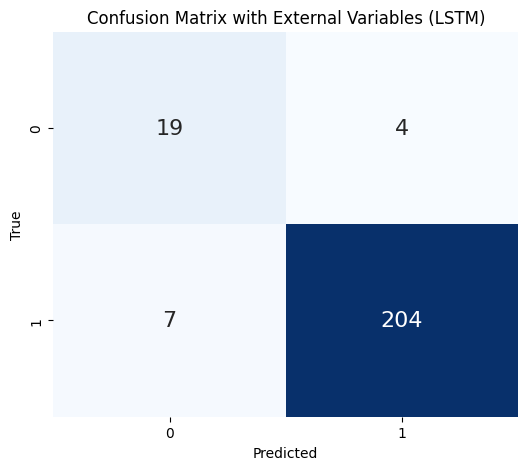

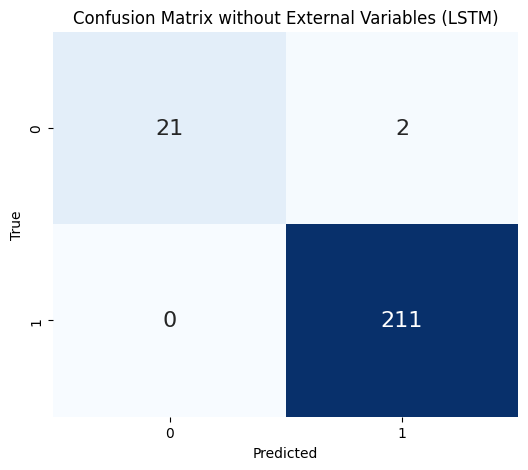

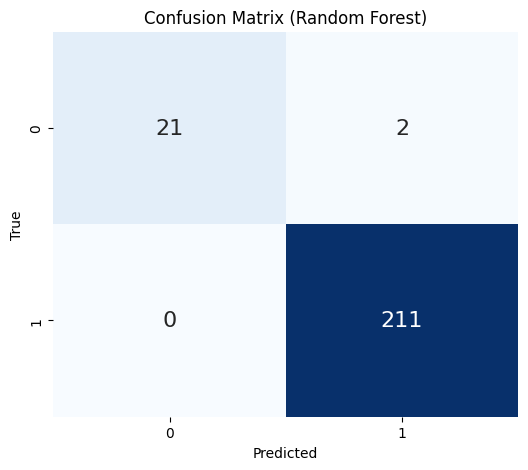

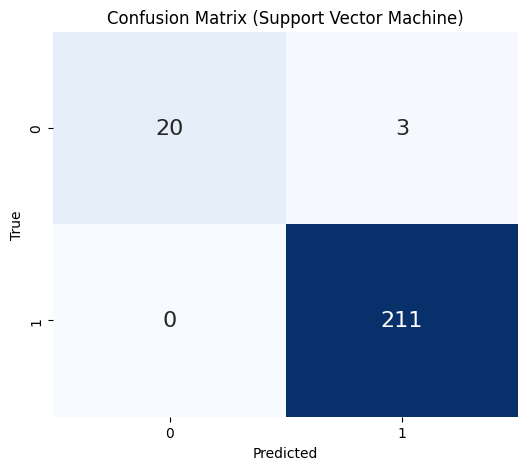

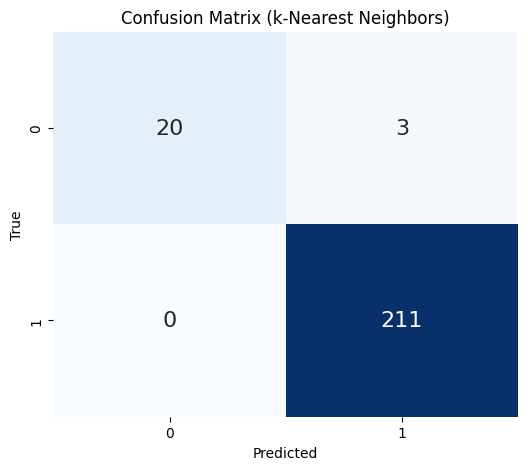

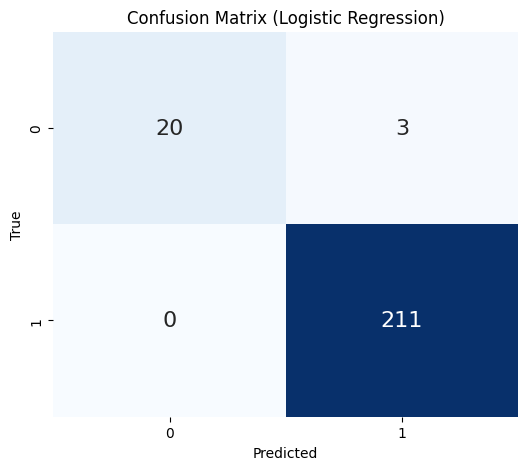

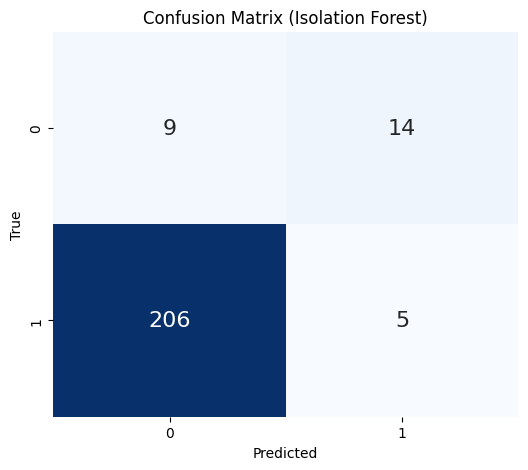

In [7]:
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrices for LSTM models
plot_confusion_matrix(cm_with_external, "Confusion Matrix with External Variables (LSTM)")
plot_confusion_matrix(cm_without_external, "Confusion Matrix without External Variables (LSTM)")

# Confusion matrices for traditional ML models
rf_cm = confusion_matrix(y_test_ml, rf_pred)
svm_cm = confusion_matrix(y_test_ml, svm_pred)
knn_cm = confusion_matrix(y_test_ml, knn_pred)
lr_cm = confusion_matrix(y_test_ml, lr_pred)
iso_forest_cm = confusion_matrix(y_test_ml, iso_forest_pred)

plot_confusion_matrix(rf_cm, "Confusion Matrix (Random Forest)")
plot_confusion_matrix(svm_cm, "Confusion Matrix (Support Vector Machine)")
plot_confusion_matrix(knn_cm, "Confusion Matrix (k-Nearest Neighbors)")
plot_confusion_matrix(lr_cm, "Confusion Matrix (Logistic Regression)")
plot_confusion_matrix(iso_forest_cm, "Confusion Matrix (Isolation Forest)")


Epoch 1/20
12/12 [==============================] - 2s 24ms/step - loss: 0.8836 - val_loss: 0.9391
Epoch 2/20
12/12 [==============================] - 0s 3ms/step - loss: 0.8738 - val_loss: 0.9285
Epoch 3/20
12/12 [==============================] - 0s 3ms/step - loss: 0.8636 - val_loss: 0.9172
Epoch 4/20
12/12 [==============================] - 0s 3ms/step - loss: 0.8523 - val_loss: 0.9050
Epoch 5/20
12/12 [==============================] - 0s 3ms/step - loss: 0.8400 - val_loss: 0.8905
Epoch 6/20
12/12 [==============================] - 0s 3ms/step - loss: 0.8251 - val_loss: 0.8718
Epoch 7/20
12/12 [==============================] - 0s 3ms/step - loss: 0.8038 - val_loss: 0.8430
Epoch 8/20
12/12 [==============================] - 0s 3ms/step - loss: 0.7686 - val_loss: 0.7852
Epoch 9/20
12/12 [==============================] - 0s 3ms/step - loss: 0.6826 - val_loss: 0.6315
Epoch 10/20
12/12 [==============================] - 0s 3ms/step - loss: 0.5114 - val_loss: 0.5564
Epoch 11/20
12/12 

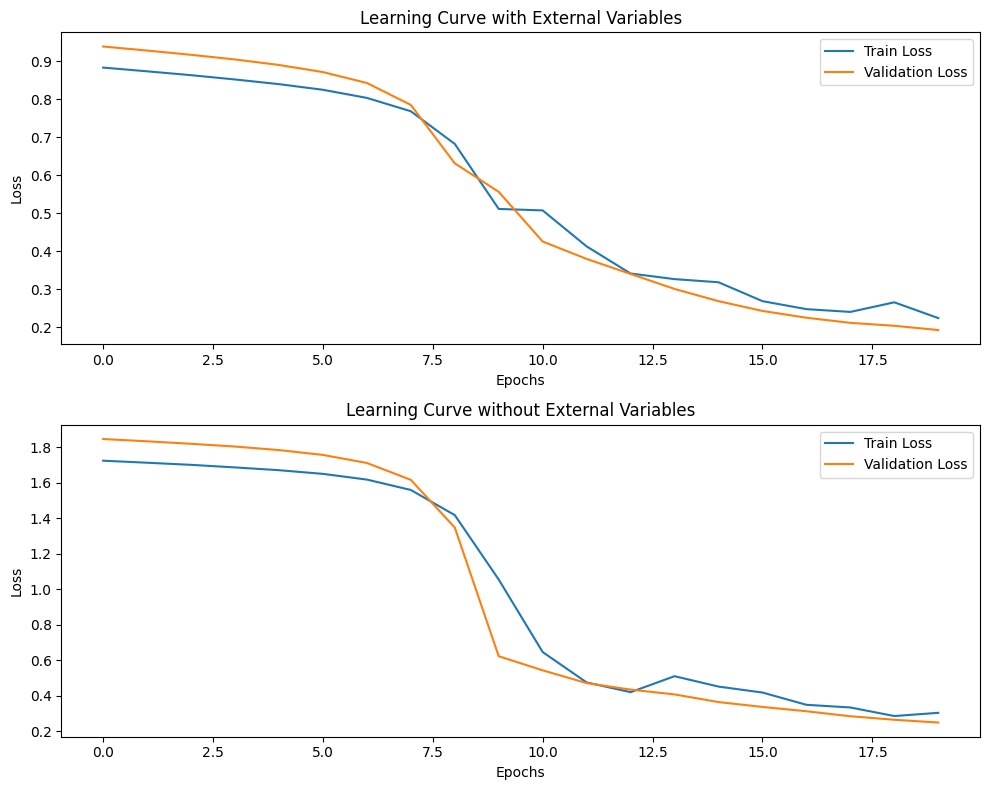

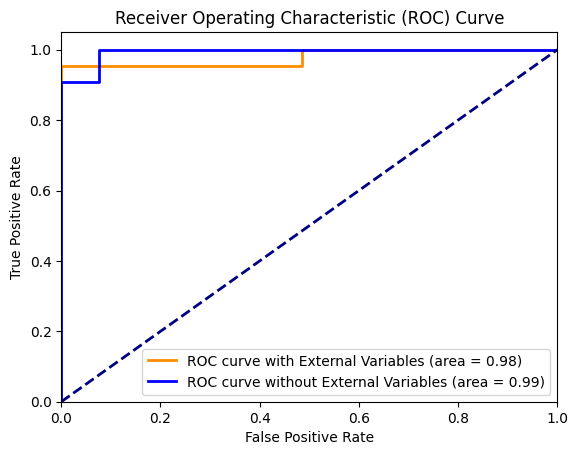

Model with External Variables
Best Threshold: 0.22377424340096108
Confusion Matrix:
 [[212   0]
 [  1  21]]
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       212
          -1       1.00      0.95      0.98        22

    accuracy                           1.00       234
   macro avg       1.00      0.98      0.99       234
weighted avg       1.00      1.00      1.00       234

MSE: 0.017094017094017096
AUC: 0.9779159519725558

Model without External Variables
Best Threshold: 0.2497044003696399
Confusion Matrix:
 [[212   0]
 [  2  20]]
Classification Report:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       212
          -1       1.00      0.91      0.95        22

    accuracy                           0.99       234
   macro avg       1.00      0.95      0.97       234
weighted avg       0.99      0.99      0.99       234

MSE: 0.03418803418803419
AUC:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, mean_squared_error, roc_curve, auc
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
file_path = 'baseline_data.csv'
df = pd.read_csv(file_path, parse_dates=['time'], index_col='time')

# Feature engineering
df['hour_of_day'] = df.index.hour

# Check for missing values and fill if any
df.fillna(method='ffill', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity', 'hour_of_day']] = scaler.fit_transform(
    df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity', 'hour_of_day']]
)

# Add temp_diff and humidity_diff columns for analysis
df['temp_diff'] = df['device_temperature'] - df['climate_temperature']
df['humidity_diff'] = df['device_humidity'] - df['climate_humidity']

# Function to add synthetic anomalies
def add_synthetic_anomalies(df, anomaly_fraction=0.1, seed=42):
    np.random.seed(seed)
    df_with_anomalies = df.copy()
    num_anomalies = int(len(df) * anomaly_fraction)
    anomaly_indices = np.random.choice(df.index, num_anomalies, replace=False)
    df_with_anomalies.loc[anomaly_indices, 'device_temperature'] += np.random.normal(5, 2, size=num_anomalies)
    df_with_anomalies['label'] = 1
    df_with_anomalies.loc[anomaly_indices, 'label'] = -1
    return df_with_anomalies

# Add synthetic anomalies
df_with_anomalies = add_synthetic_anomalies(df)

# Split the data
train_size = int(len(df_with_anomalies) * 0.8)
train, test = np.split(df_with_anomalies, [train_size])
val_size = int(len(train) * 0.2)
train, val = np.split(train, [len(train) - val_size])

# Function to prepare data and train the model
def train_and_evaluate_model(features, train, val, test):
    X_train = train[features].values.reshape((train.shape[0], 1, len(features)))
    X_val = val[features].values.reshape((val.shape[0], 1, len(features)))
    X_test = test[features].values.reshape((test.shape[0], 1, len(features)))

    model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(32, activation='relu', return_sequences=False),
        RepeatVector(X_train.shape[1]),
        LSTM(32, activation='relu', return_sequences=True),
        Dropout(0.2),
        LSTM(16, activation='relu', return_sequences=True),
        TimeDistributed(Dense(X_train.shape[2]))
    ])

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, X_train, epochs=20, batch_size=64, validation_data=(X_val, X_val), callbacks=[early_stopping])

    X_test_pred = model.predict(X_test)
    test_mse_loss = np.mean(np.square(X_test_pred - X_test), axis=2).flatten()

    # Determine the threshold
    thresholds = np.linspace(0, max(test_mse_loss), 100)
    best_threshold = thresholds[np.argmax([precision_score(test['label'], [1 if score < threshold else -1 for score in test_mse_loss], pos_label=-1) *
                                            recall_score(test['label'], [1 if score < threshold else -1 for score in test_mse_loss], pos_label=-1) for threshold in thresholds])]

    y_pred = [1 if score < best_threshold else -1 for score in test_mse_loss]
    cm = confusion_matrix(test['label'], y_pred, labels=[1, -1])
    report = classification_report(test['label'], y_pred, labels=[1, -1])

    # Calculate MSE
    mse = mean_squared_error(test['label'], y_pred)

    return model, best_threshold, cm, report, history, mse, test_mse_loss, test['label']

# Train and evaluate the model with external variables
features_with_external = ['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity', 'hour_of_day']
model_with_external, best_threshold_with_external, cm_with_external, report_with_external, history_with_external, mse_with_external, test_mse_loss_with_external, test_labels_with_external = train_and_evaluate_model(features_with_external, train, val, test)

# Train and evaluate the model without external variables
features_without_external = ['device_temperature', 'device_humidity']
model_without_external, best_threshold_without_external, cm_without_external, report_without_external, history_without_external, mse_without_external, test_mse_loss_without_external, test_labels_without_external = train_and_evaluate_model(features_without_external, train, val, test)

# Plot Learning Curves
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(history_with_external.history['loss'], label='Train Loss')
plt.plot(history_with_external.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve with External Variables')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history_without_external.history['loss'], label='Train Loss')
plt.plot(history_without_external.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve without External Variables')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot ROC Curves
fpr_with_external, tpr_with_external, _ = roc_curve(test_labels_with_external, test_mse_loss_with_external, pos_label=-1)
roc_auc_with_external = auc(fpr_with_external, tpr_with_external)

fpr_without_external, tpr_without_external, _ = roc_curve(test_labels_without_external, test_mse_loss_without_external, pos_label=-1)
roc_auc_without_external = auc(fpr_without_external, tpr_without_external)

plt.figure()
plt.plot(fpr_with_external, tpr_with_external, color='darkorange', lw=2, label='ROC curve with External Variables (area = %0.2f)' % roc_auc_with_external)
plt.plot(fpr_without_external, tpr_without_external, color='blue', lw=2, label='ROC curve without External Variables (area = %0.2f)' % roc_auc_without_external)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print results for model with external variables
print("Model with External Variables")
print("Best Threshold:", best_threshold_with_external)
print("Confusion Matrix:\n", cm_with_external)
print("Classification Report:\n", report_with_external)
print("MSE:", mse_with_external)
print(f"AUC: {roc_auc_with_external}")

# Print results for model without external variables
print("\nModel without External Variables")
print("Best Threshold:", best_threshold_without_external)
print("Confusion Matrix:\n", cm_without_external)
print("Classification Report:\n", report_without_external)
print("MSE:", mse_without_external)
print(f"AUC: {roc_auc_without_external}")


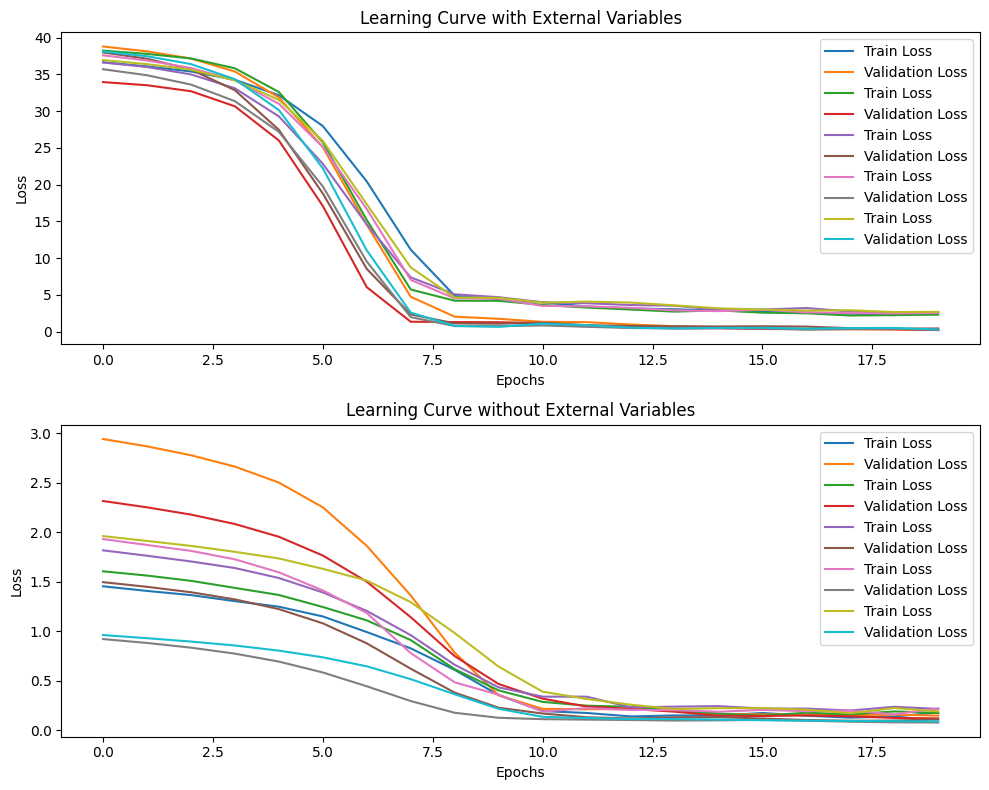

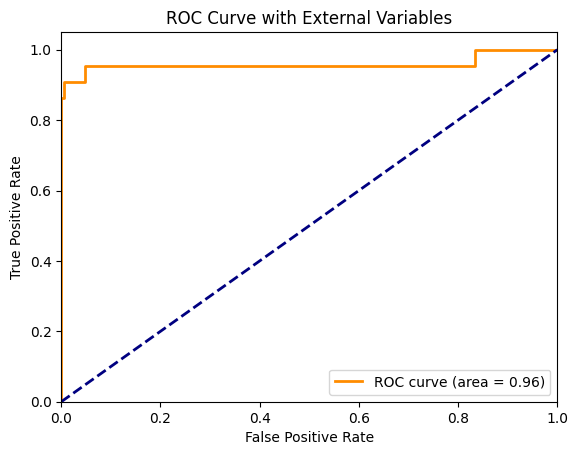

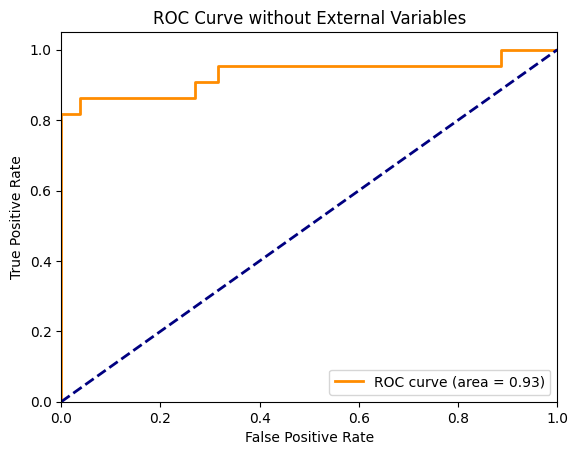

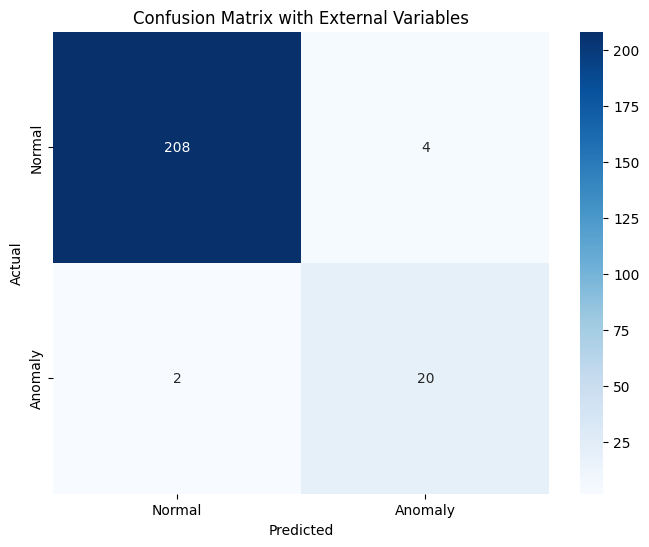

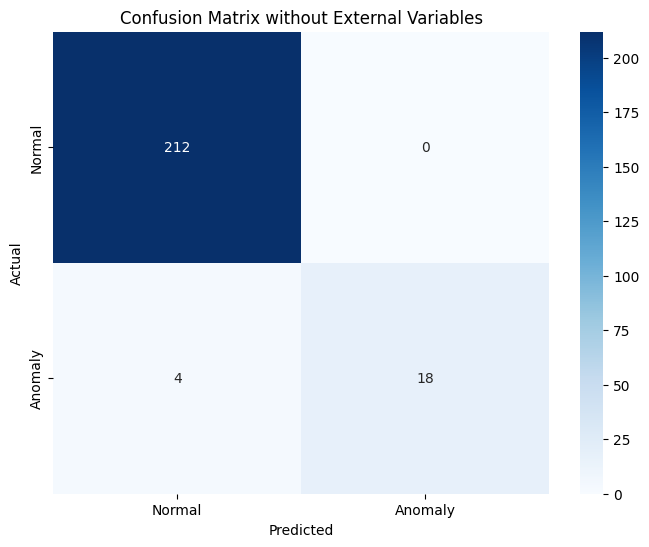

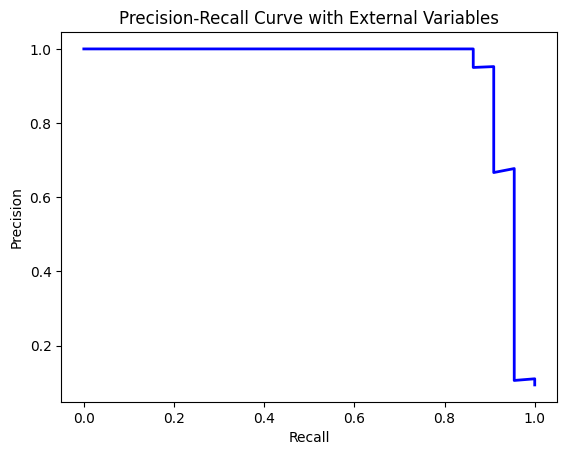

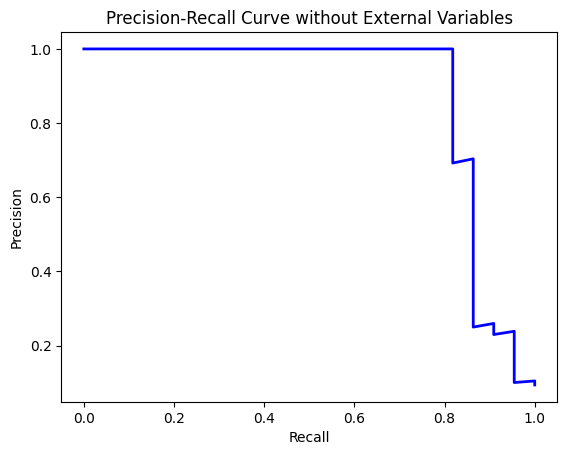

With External Variables
Best Threshold: 0.41431741605375694
Confusion Matrix:
 [[208   4]
 [  2  20]]
Classification Report:
               precision    recall  f1-score   support

           1       0.99      0.98      0.99       212
          -1       0.83      0.91      0.87        22

    accuracy                           0.97       234
   macro avg       0.91      0.95      0.93       234
weighted avg       0.98      0.97      0.97       234

Average Precision: 1.0
Average Recall: 1.0
MSE: 0.10256410256410256
AUC: 0.9596912521440822

Without External Variables
Best Threshold: 0.15824404073849013
Confusion Matrix:
 [[212   0]
 [  4  18]]
Classification Report:
               precision    recall  f1-score   support

           1       0.98      1.00      0.99       212
          -1       1.00      0.82      0.90        22

    accuracy                           0.98       234
   macro avg       0.99      0.91      0.95       234
weighted avg       0.98      0.98      0.98       234

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, auc, mean_squared_error, precision_recall_curve
from sklearn.model_selection import KFold
from scipy.stats import ttest_rel
import seaborn as sns
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
file_path = 'baseline_data.csv'
df = pd.read_csv(file_path, parse_dates=['time'], index_col='time')

# Check for missing values and fill if any
df.fillna(method='ffill', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity']] = scaler.fit_transform(
    df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity']]
)

# Feature engineering
df['temp_diff'] = df['device_temperature'] - df['climate_temperature']
df['humidity_diff'] = df['device_humidity'] - df['climate_humidity']
df['hour_of_day'] = df.index.hour

# Function to add synthetic anomalies
def add_synthetic_anomalies(df, anomaly_fraction=0.1, seed=42):
    np.random.seed(seed)
    df_with_anomalies = df.copy()
    num_anomalies = int(len(df) * anomaly_fraction)
    anomaly_indices = np.random.choice(df.index, num_anomalies, replace=False)
    df_with_anomalies.loc[anomaly_indices, 'device_temperature'] += np.random.normal(5, 2, size=num_anomalies)
    df_with_anomalies['label'] = 1
    df_with_anomalies.loc[anomaly_indices, 'label'] = -1
    return df_with_anomalies

# Add synthetic anomalies
df_with_anomalies = add_synthetic_anomalies(df)

# Split the data
train_size = int(len(df_with_anomalies) * 0.8)
train, test = np.split(df_with_anomalies, [train_size])
val_size = int(len(train) * 0.2)
train, val = np.split(train, [len(train) - val_size])

# Function to prepare data and train the model
def train_and_evaluate(features, train, val, test, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    precision_scores = []
    recall_scores = []
    best_thresholds = []
    histories = []
    
    for train_index, val_index in kf.split(train):
        train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]
        X_train = train_fold[features].values.reshape((train_fold.shape[0], 1, len(features)))
        X_val = val_fold[features].values.reshape((val_fold.shape[0], 1, len(features)))
        X_test = test[features].values.reshape((test.shape[0], 1, len(features)))

        model = Sequential([
            LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            Dropout(0.2),
            RepeatVector(X_train.shape[1]),
            LSTM(32, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            Dropout(0.2),
            TimeDistributed(Dense(X_train.shape[2]))
        ])

        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse')
        history = model.fit(X_train, X_train, epochs=20, batch_size=64, validation_data=(X_val, X_val), verbose=0)
        histories.append(history)

        X_val_pred = model.predict(X_val)
        val_mse_loss = np.mean(np.square(X_val_pred - X_val), axis=2).flatten()
        
        thresholds = np.linspace(0, max(val_mse_loss), 100)
        precision_scores_fold = []
        recall_scores_fold = []

        for threshold in thresholds:
            y_pred = [1 if score < threshold else -1 for score in val_mse_loss]
            precision = precision_score(val_fold['label'], y_pred, pos_label=-1)
            recall = recall_score(val_fold['label'], y_pred, pos_label=-1)
            precision_scores_fold.append(precision)
            recall_scores_fold.append(recall)

        best_threshold = thresholds[np.argmax([p * r for p, r in zip(precision_scores_fold, recall_scores_fold)])]
        best_thresholds.append(best_threshold)
        precision_scores.append(max(precision_scores_fold))
        recall_scores.append(max(recall_scores_fold))
    
    best_threshold = np.mean(best_thresholds)
    X_test_pred = model.predict(X_test)
    test_mse_loss = np.mean(np.square(X_test_pred - X_test), axis=2).flatten()
    y_pred = [1 if score < best_threshold else -1 for score in test_mse_loss]

    cm = confusion_matrix(test['label'], y_pred, labels=[1, -1])
    report = classification_report(test['label'], y_pred, labels=[1, -1])

    # Calculate MSE for the test set
    mse = mean_squared_error(test['label'], y_pred)

    return best_threshold, cm, report, np.mean(precision_scores), np.mean(recall_scores), test_mse_loss, test['label'].values, histories, mse

# Train and evaluate the model with external variables
features_with_external = ['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity', 'hour_of_day']
best_threshold_with_external, cm_with_external, report_with_external, avg_precision_with_external, avg_recall_with_external, test_mse_loss_with_external, test_labels_with_external, histories_with_external, mse_with_external = train_and_evaluate(features_with_external, train, val, test)

# Train and evaluate the model without external variables
features_without_external = ['device_temperature', 'device_humidity']
best_threshold_without_external, cm_without_external, report_without_external, avg_precision_without_external, avg_recall_without_external, test_mse_loss_without_external, test_labels_without_external, histories_without_external, mse_without_external = train_and_evaluate(features_without_external, train, val, test)

# Plot Learning Curves
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
for history in histories_with_external:
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve with External Variables')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
for history in histories_without_external:
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve without External Variables')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot ROC Curves
def plot_roc_curve(test_labels, test_mse_loss, title):
    fpr, tpr, _ = roc_curve(test_labels, test_mse_loss, pos_label=-1)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

roc_auc_with_external = plot_roc_curve(test_labels_with_external, test_mse_loss_with_external, "ROC Curve with External Variables")
roc_auc_without_external = plot_roc_curve(test_labels_without_external, test_mse_loss_without_external, "ROC Curve without External Variables")

# Plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

plot_confusion_matrix(cm_with_external, "Confusion Matrix with External Variables")
plot_confusion_matrix(cm_without_external, "Confusion Matrix without External Variables")

# Plot precision-recall curve
def plot_precision_recall_curve(test_labels, test_mse_loss, title):
    precision, recall, _ = precision_recall_curve(test_labels, test_mse_loss, pos_label=-1)
    plt.figure()
    plt.plot(recall, precision, color='b', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.show()

plot_precision_recall_curve(test_labels_with_external, test_mse_loss_with_external, "Precision-Recall Curve with External Variables")
plot_precision_recall_curve(test_labels_without_external, test_mse_loss_without_external, "Precision-Recall Curve without External Variables")

# Print results for model with external variables
print("With External Variables")
print("Best Threshold:", best_threshold_with_external)
print("Confusion Matrix:\n", cm_with_external)
print("Classification Report:\n", report_with_external)
print("Average Precision:", avg_precision_with_external)
print("Average Recall:", avg_recall_with_external)
print("MSE:", mse_with_external)
print(f"AUC: {roc_auc_with_external}")

# Print results for model without external variables
print("\nWithout External Variables")
print("Best Threshold:", best_threshold_without_external)
print("Confusion Matrix:\n", cm_without_external)
print("Classification Report:\n", report_without_external)
print("Average Precision:", avg_precision_without_external)
print("Average Recall:", avg_recall_without_external)
print("MSE:", mse_without_external)
print(f"AUC: {roc_auc_without_external}")


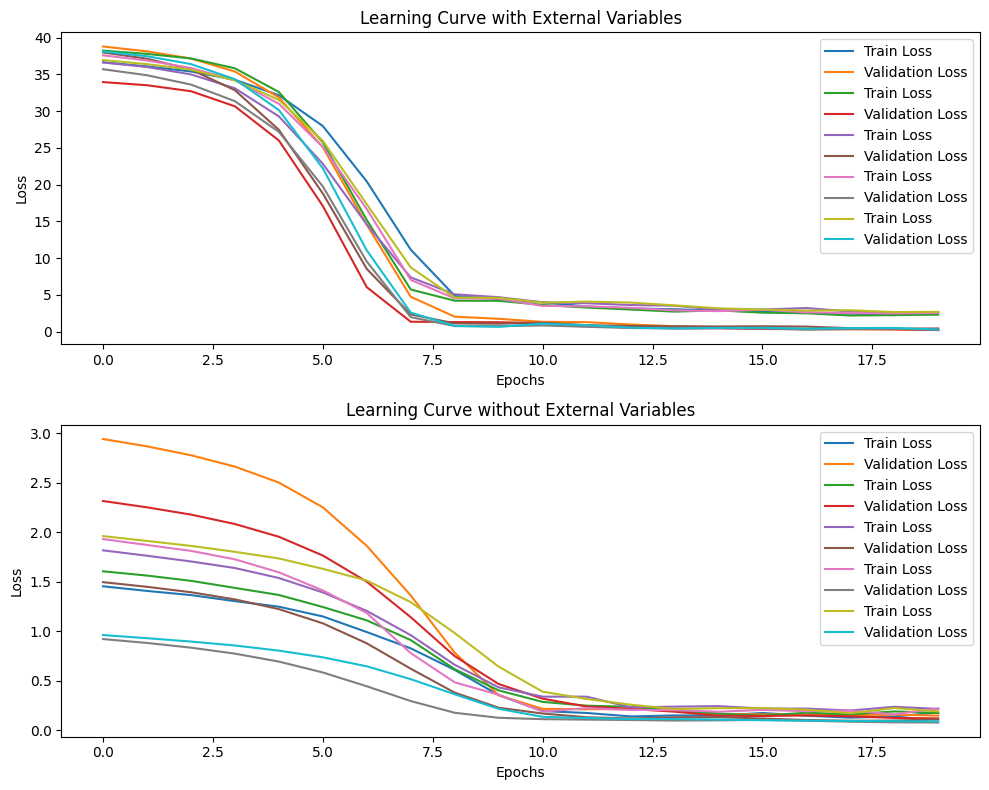

Random Forest
[[ 21   2]
 [  0 211]]
              precision    recall  f1-score   support

          -1       1.00      0.91      0.95        23
           1       0.99      1.00      1.00       211

    accuracy                           0.99       234
   macro avg       1.00      0.96      0.97       234
weighted avg       0.99      0.99      0.99       234

MSE: 0.03418803418803419

Support Vector Machine
[[ 20   3]
 [  0 211]]
              precision    recall  f1-score   support

          -1       1.00      0.87      0.93        23
           1       0.99      1.00      0.99       211

    accuracy                           0.99       234
   macro avg       0.99      0.93      0.96       234
weighted avg       0.99      0.99      0.99       234

MSE: 0.05128205128205128

k-Nearest Neighbors
[[ 20   3]
 [  0 211]]
              precision    recall  f1-score   support

          -1       1.00      0.87      0.93        23
           1       0.99      1.00      0.99       211

    

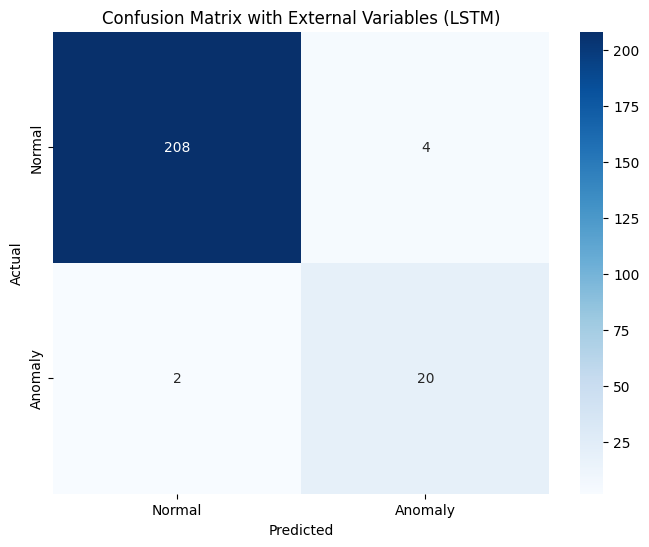

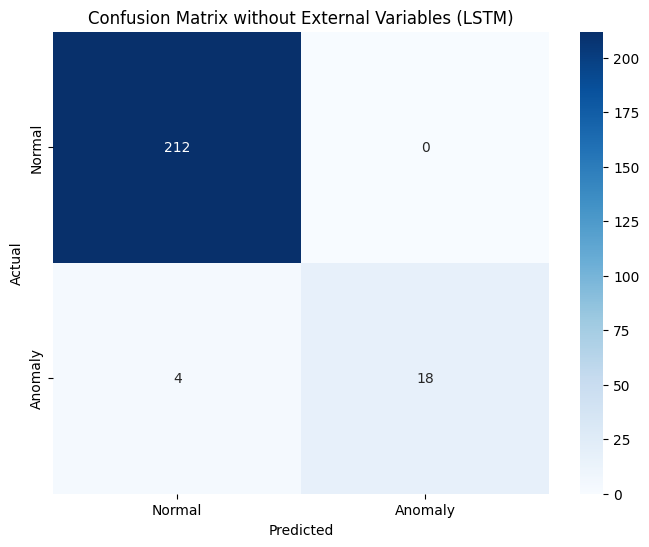

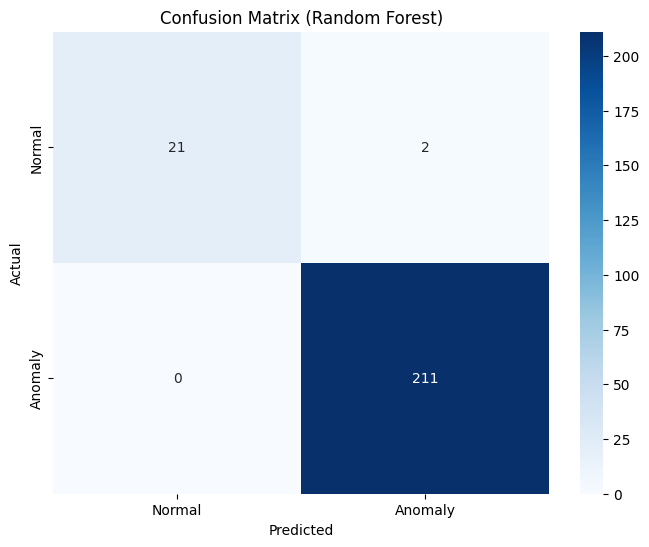

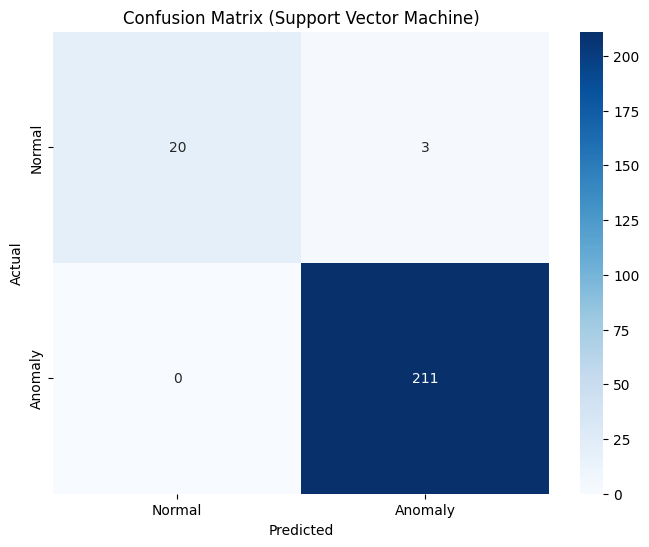

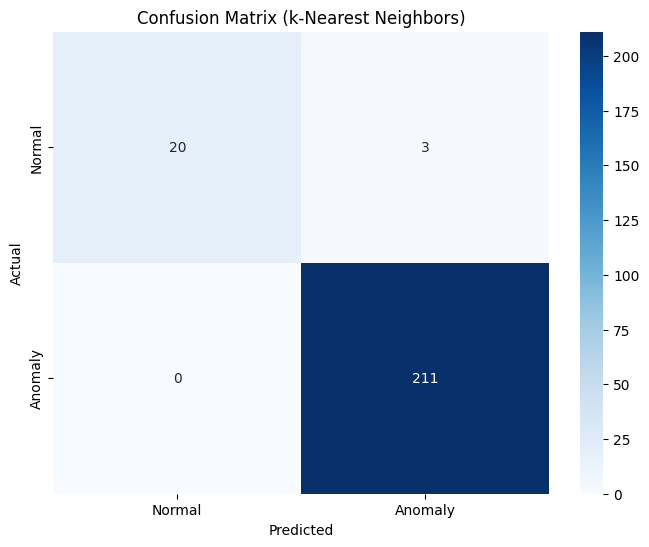

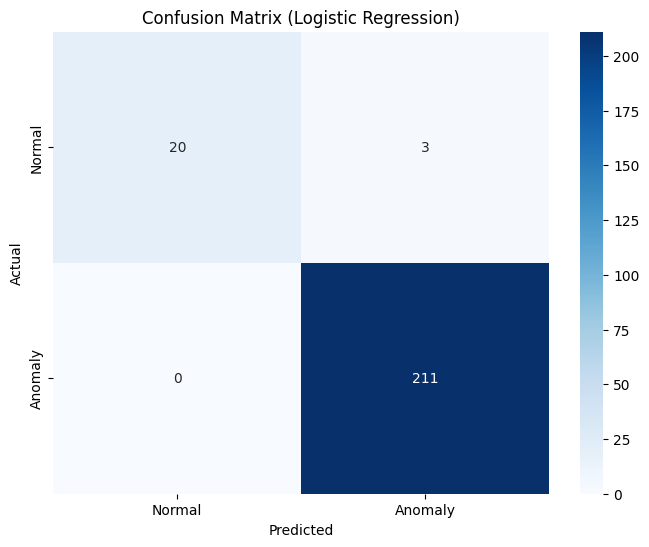

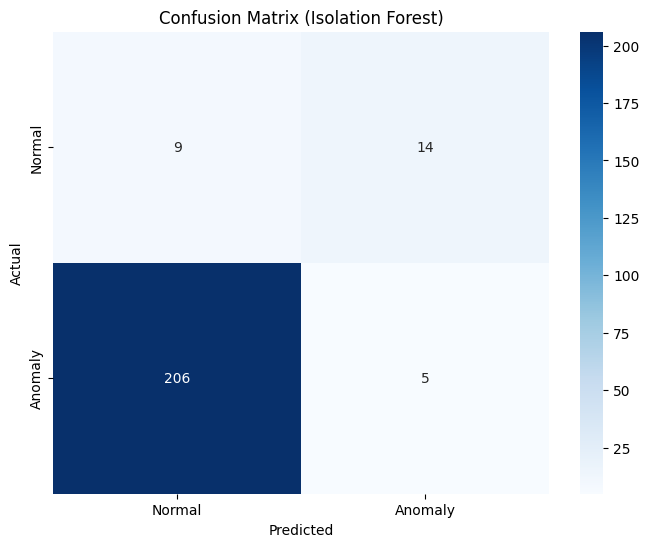

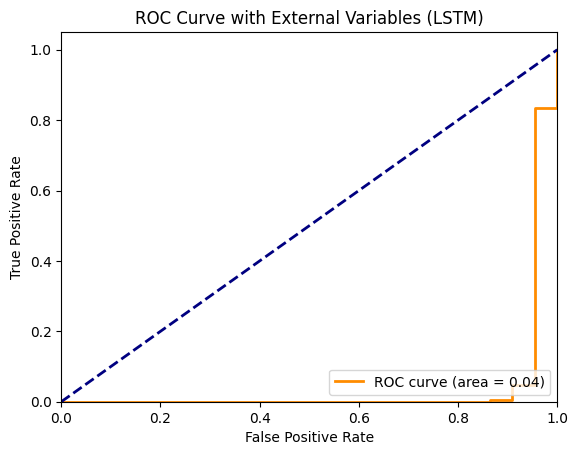

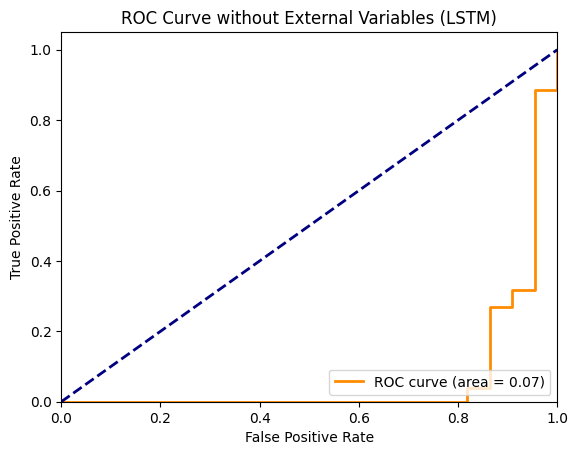

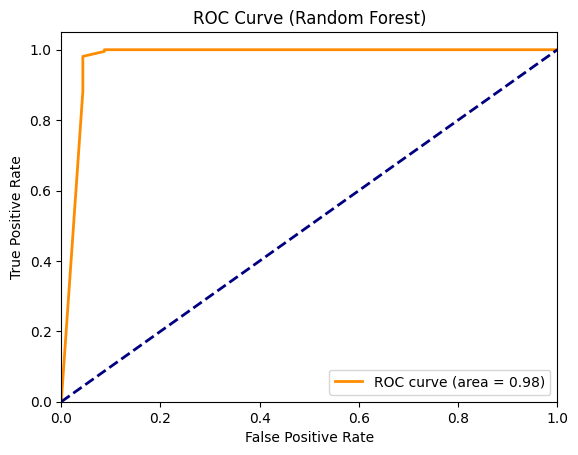

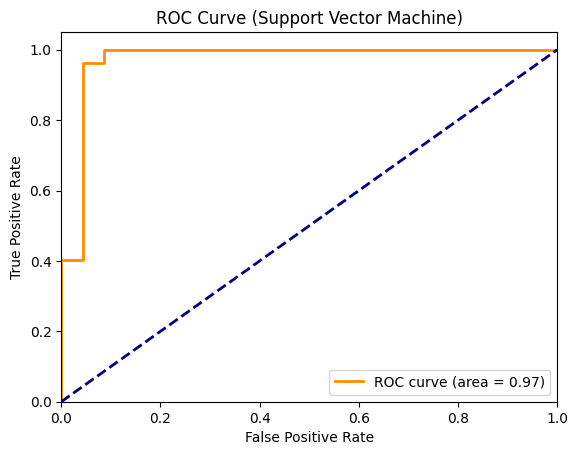

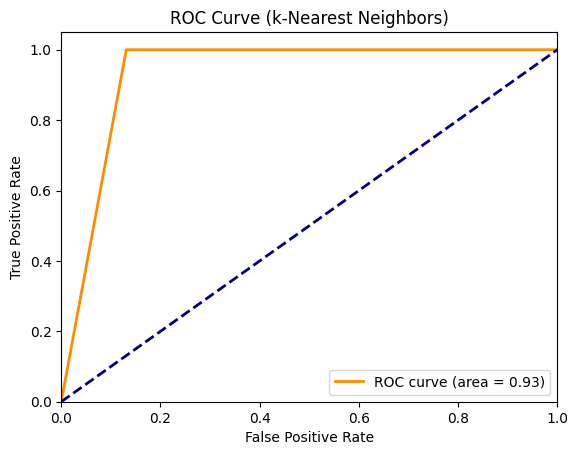

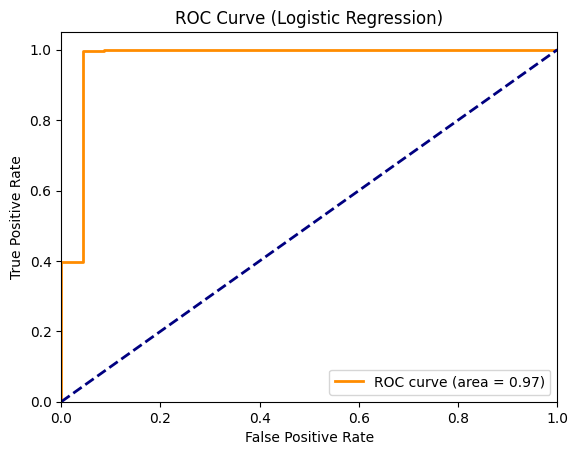

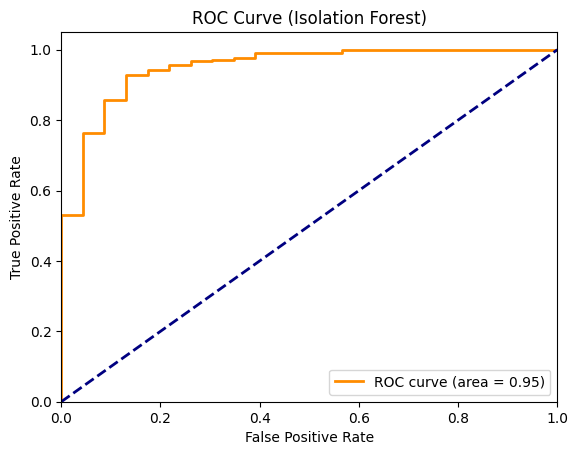

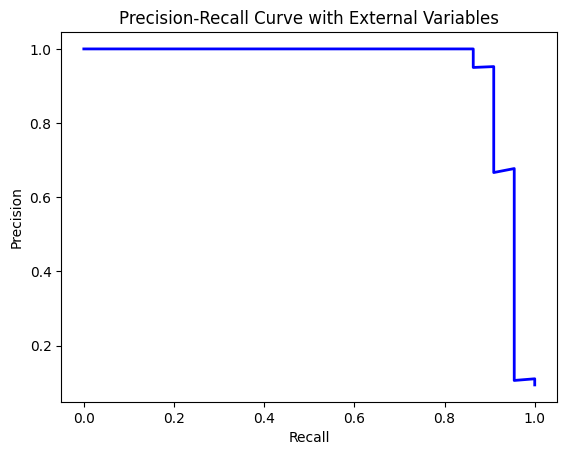

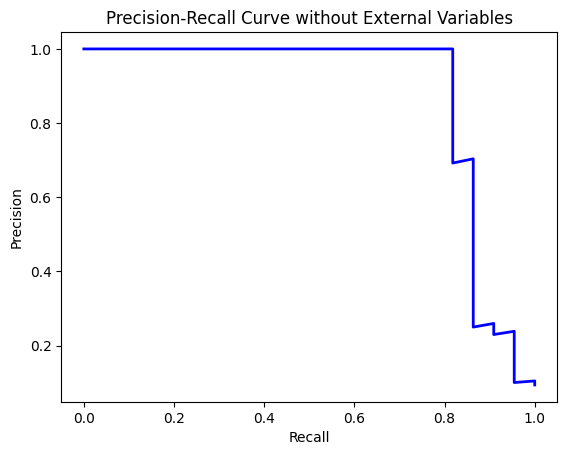

With External Variables
Best Threshold: 0.41431741605375694
Confusion Matrix:
 [[208   4]
 [  2  20]]
Classification Report:
               precision    recall  f1-score   support

           1       0.99      0.98      0.99       212
          -1       0.83      0.91      0.87        22

    accuracy                           0.97       234
   macro avg       0.91      0.95      0.93       234
weighted avg       0.98      0.97      0.97       234

Average Precision: 1.0
Average Recall: 1.0
MSE: 0.10256410256410256
AUC: 0.040308747855917634

Without External Variables
Best Threshold: 0.15824404073849013
Confusion Matrix:
 [[212   0]
 [  4  18]]
Classification Report:
               precision    recall  f1-score   support

           1       0.98      1.00      0.99       212
          -1       1.00      0.82      0.90        22

    accuracy                           0.98       234
   macro avg       0.99      0.91      0.95       234
weighted avg       0.98      0.98      0.98       2

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, auc, mean_squared_error, precision_recall_curve
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from scipy.stats import ttest_rel
import seaborn as sns
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
file_path = 'baseline_data.csv'
df = pd.read_csv(file_path, parse_dates=['time'], index_col='time')

# Check for missing values and fill if any
df.fillna(method='ffill', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity']] = scaler.fit_transform(
    df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity']]
)

# Feature engineering
df['temp_diff'] = df['device_temperature'] - df['climate_temperature']
df['humidity_diff'] = df['device_humidity'] - df['climate_humidity']
df['hour_of_day'] = df.index.hour

# Function to add synthetic anomalies
def add_synthetic_anomalies(df, anomaly_fraction=0.1, seed=42):
    np.random.seed(seed)
    df_with_anomalies = df.copy()
    num_anomalies = int(len(df) * anomaly_fraction)
    anomaly_indices = np.random.choice(df.index, num_anomalies, replace=False)
    df_with_anomalies.loc[anomaly_indices, 'device_temperature'] += np.random.normal(5, 2, size=num_anomalies)
    df_with_anomalies['label'] = 1
    df_with_anomalies.loc[anomaly_indices, 'label'] = -1
    return df_with_anomalies

# Add synthetic anomalies
df_with_anomalies = add_synthetic_anomalies(df)

# Split the data
train_size = int(len(df_with_anomalies) * 0.8)
train, test = np.split(df_with_anomalies, [train_size])
val_size = int(len(train) * 0.2)
train, val = np.split(train, [len(train) - val_size])

# Function to prepare data and train the model
def train_and_evaluate(features, train, val, test, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    precision_scores = []
    recall_scores = []
    best_thresholds = []
    histories = []
    
    for train_index, val_index in kf.split(train):
        train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]
        X_train = train_fold[features].values.reshape((train_fold.shape[0], 1, len(features)))
        X_val = val_fold[features].values.reshape((val_fold.shape[0], 1, len(features)))
        X_test = test[features].values.reshape((test.shape[0], 1, len(features)))

        model = Sequential([
            LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            Dropout(0.2),
            RepeatVector(X_train.shape[1]),
            LSTM(32, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            Dropout(0.2),
            TimeDistributed(Dense(X_train.shape[2]))
        ])

        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse')
        history = model.fit(X_train, X_train, epochs=20, batch_size=64, validation_data=(X_val, X_val), verbose=0)
        histories.append(history)

        X_val_pred = model.predict(X_val)
        val_mse_loss = np.mean(np.square(X_val_pred - X_val), axis=2).flatten()
        
        thresholds = np.linspace(0, max(val_mse_loss), 100)
        precision_scores_fold = []
        recall_scores_fold = []

        for threshold in thresholds:
            y_pred = [1 if score < threshold else -1 for score in val_mse_loss]
            precision = precision_score(val_fold['label'], y_pred, pos_label=-1)
            recall = recall_score(val_fold['label'], y_pred, pos_label=-1)
            precision_scores_fold.append(precision)
            recall_scores_fold.append(recall)

        best_threshold = thresholds[np.argmax([p * r for p, r in zip(precision_scores_fold, recall_scores_fold)])]
        best_thresholds.append(best_threshold)
        precision_scores.append(max(precision_scores_fold))
        recall_scores.append(max(recall_scores_fold))
    
    best_threshold = np.mean(best_thresholds)
    X_test_pred = model.predict(X_test)
    test_mse_loss = np.mean(np.square(X_test_pred - X_test), axis=2).flatten()
    y_pred = [1 if score < best_threshold else -1 for score in test_mse_loss]

    cm = confusion_matrix(test['label'], y_pred, labels=[1, -1])
    report = classification_report(test['label'], y_pred, labels=[1, -1])

    # Calculate MSE for the test set
    mse = mean_squared_error(test['label'], y_pred)

    return best_threshold, cm, report, np.mean(precision_scores), np.mean(recall_scores), test_mse_loss, test['label'].values, histories, mse

# Train and evaluate the model with external variables
features_with_external = ['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity', 'hour_of_day']
best_threshold_with_external, cm_with_external, report_with_external, avg_precision_with_external, avg_recall_with_external, test_mse_loss_with_external, test_labels_with_external, histories_with_external, mse_with_external = train_and_evaluate(features_with_external, train, val, test)

# Train and evaluate the model without external variables
features_without_external = ['device_temperature', 'device_humidity']
best_threshold_without_external, cm_without_external, report_without_external, avg_precision_without_external, avg_recall_without_external, test_mse_loss_without_external, test_labels_without_external, histories_without_external, mse_without_external = train_and_evaluate(features_without_external, train, val, test)

# Plot Learning Curves
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
for history in histories_with_external:
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve with External Variables')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
for history in histories_without_external:
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve without External Variables')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Traditional Machine Learning Models

# Prepare data
X = df_with_anomalies[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity', 'hour_of_day']]
y = df_with_anomalies['label']
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to train and evaluate traditional ML models
def evaluate_ml_model(model, model_name):
    model.fit(X_train_ml, y_train_ml)
    y_pred = model.predict(X_test_ml)
    cm = confusion_matrix(y_test_ml, y_pred)
    report = classification_report(y_test_ml, y_pred)
    
    # Calculate MSE for the test set
    mse = mean_squared_error(y_test_ml, y_pred)
    
    print(model_name)
    print(cm)
    print(report)
    print(f"MSE: {mse}\n")
    
    return y_pred, mse, cm, report

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pred, rf_mse, rf_cm, rf_report = evaluate_ml_model(rf, "Random Forest")

# Support Vector Machine
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm_pred, svm_mse, svm_cm, svm_report = evaluate_ml_model(svm, "Support Vector Machine")

# k-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn_pred, knn_mse, knn_cm, knn_report = evaluate_ml_model(knn, "k-Nearest Neighbors")

# Logistic Regression
lr = LogisticRegression(random_state=42)
lr_pred, lr_mse, lr_cm, lr_report = evaluate_ml_model(lr, "Logistic Regression")

# Isolation Forest (for anomaly detection)
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_train_ml)
iso_forest_pred = iso_forest.predict(X_test_ml)
iso_forest_pred = np.where(iso_forest_pred == 1, -1, 1)  # Convert 1 to -1 for normal and -1 to 1 for anomalies
iso_forest_cm = confusion_matrix(y_test_ml, iso_forest_pred)
iso_forest_report = classification_report(y_test_ml, iso_forest_pred)
iso_forest_mse = mean_squared_error(y_test_ml, iso_forest.decision_function(X_test_ml))
print("Isolation Forest")
print(iso_forest_cm)
print(iso_forest_report)
print(f"MSE: {iso_forest_mse}\n")

# Plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

# Plot confusion matrices for LSTM models
plot_confusion_matrix(cm_with_external, "Confusion Matrix with External Variables (LSTM)")
plot_confusion_matrix(cm_without_external, "Confusion Matrix without External Variables (LSTM)")

# Confusion matrices for traditional ML models
plot_confusion_matrix(rf_cm, "Confusion Matrix (Random Forest)")
plot_confusion_matrix(svm_cm, "Confusion Matrix (Support Vector Machine)")
plot_confusion_matrix(knn_cm, "Confusion Matrix (k-Nearest Neighbors)")
plot_confusion_matrix(lr_cm, "Confusion Matrix (Logistic Regression)")
plot_confusion_matrix(iso_forest_cm, "Confusion Matrix (Isolation Forest)")

# Plot ROC Curves
def plot_roc_curve(y_true, y_pred, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

roc_auc_with_external = plot_roc_curve(test_labels_with_external, test_mse_loss_with_external, "ROC Curve with External Variables (LSTM)")
roc_auc_without_external = plot_roc_curve(test_labels_without_external, test_mse_loss_without_external, "ROC Curve without External Variables (LSTM)")

# For traditional ML models
rf_roc_auc = plot_roc_curve(y_test_ml, rf.predict_proba(X_test_ml)[:, 1], "ROC Curve (Random Forest)")
svm_roc_auc = plot_roc_curve(y_test_ml, svm.decision_function(X_test_ml), "ROC Curve (Support Vector Machine)")
knn_roc_auc = plot_roc_curve(y_test_ml, knn.predict_proba(X_test_ml)[:, 1], "ROC Curve (k-Nearest Neighbors)")
lr_roc_auc = plot_roc_curve(y_test_ml, lr.predict_proba(X_test_ml)[:, 1], "ROC Curve (Logistic Regression)")
iso_forest_roc_auc = plot_roc_curve(y_test_ml, iso_forest.decision_function(X_test_ml), "ROC Curve (Isolation Forest)")

# Plot precision-recall curves
def plot_precision_recall_curve(test_labels, test_mse_loss, title):
    precision, recall, _ = precision_recall_curve(test_labels, test_mse_loss, pos_label=-1)
    plt.figure()
    plt.plot(recall, precision, color='b', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.show()

plot_precision_recall_curve(test_labels_with_external, test_mse_loss_with_external, "Precision-Recall Curve with External Variables")
plot_precision_recall_curve(test_labels_without_external, test_mse_loss_without_external, "Precision-Recall Curve without External Variables")

# Print results for model with external variables
print("With External Variables")
print("Best Threshold:", best_threshold_with_external)
print("Confusion Matrix:\n", cm_with_external)
print("Classification Report:\n", report_with_external)
print("Average Precision:", avg_precision_with_external)
print("Average Recall:", avg_recall_with_external)
print("MSE:", mse_with_external)
print(f"AUC: {roc_auc_with_external}")

# Print results for model without external variables
print("\nWithout External Variables")
print("Best Threshold:", best_threshold_without_external)
print("Confusion Matrix:\n", cm_without_external)
print("Classification Report:\n", report_without_external)
print("Average Precision:", avg_precision_without_external)
print("Average Recall:", avg_recall_without_external)
print("MSE:", mse_without_external)
print(f"AUC: {roc_auc_without_external}")

# Print results for traditional ML models
print("\nRandom Forest")
print(rf_cm)
print(rf_report)
print(f"MSE: {rf_mse}")
print(f"AUC: {rf_roc_auc}")

print("\nSupport Vector Machine")
print(svm_cm)
print(svm_report)
print(f"MSE: {svm_mse}")
print(f"AUC: {svm_roc_auc}")

print("\nk-Nearest Neighbors")
print(knn_cm)
print(knn_report)
print(f"MSE: {knn_mse}")
print(f"AUC: {knn_roc_auc}")

print("\nLogistic Regression")
print(lr_cm)
print(lr_report)
print(f"MSE: {lr_mse}")
print(f"AUC: {lr_roc_auc}")

print("\nIsolation Forest")
print(iso_forest_cm)
print(iso_forest_report)
print(f"MSE: {iso_forest_mse}")
print(f"AUC: {iso_forest_roc_auc}")
